### HTML

In [52]:
# %%HTML 
# <script>
#     function luc21893_refresh_cell(cell) {
#         if( cell.luc21893 ) return;
#         cell.luc21893 = true;
#         console.debug('New code cell found...' );
        
#         var div = document.createElement('DIV');            
#         cell.parentNode.insertBefore( div, cell.nextSibling );
#         div.style.textAlign = 'right';
#         var a = document.createElement('A');
#         div.appendChild(a);
#         a.href='#'
#         a.luc21893 = cell;
#         a.setAttribute( 'onclick', "luc21893_toggle(this); return false;" );

#         cell.style.visibility='hidden';
#         cell.style.position='absolute';
#         a.innerHTML = '[show code]';        
                
#     }
#     function luc21893_refresh() {                
#         if( document.querySelector('.code_cell .input') == null ) {            
#             // it apeears that I am in a exported html
#             // hide this code
#             var codeCells = document.querySelectorAll('.jp-InputArea')
#             codeCells[0].style.visibility = 'hidden';
#             codeCells[0].style.position = 'absolute';                        
#             for( var i = 1; i < codeCells.length; i++ ) {
#                 luc21893_refresh_cell(codeCells[i].parentNode)
#             }
#             window.onload = luc21893_refresh;
#         }                 
#         else {
#             // it apperas that I am in a jupyter editor
#             var codeCells = document.querySelectorAll('.code_cell .input')
#             for( var i = 0; i < codeCells.length; i++ ) {
#                 luc21893_refresh_cell(codeCells[i])
#             }            
#             window.setTimeout( luc21893_refresh, 1000 )
#         }        
#     }
    
#     function luc21893_toggle(a) {
#         if( a.luc21893.style.visibility=='hidden' ) {
#             a.luc21893.style.visibility='visible';        
#             a.luc21893.style.position='';
#             a.innerHTML = '[hide code]';
#         }
#         else {
#             a.luc21893.style.visibility='hidden';        
#             a.luc21893.style.position='absolute';
#             a.innerHTML = '[show code]';
#         }
#     }
    
#     luc21893_refresh()
# </script>

### imports

In [73]:
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils.validation import check_is_fitted
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from skimpy import clean_columns

### load data

In [231]:
df_train = pd.read_csv('~/Downloads/latest_signals_dataset/example_training_data_yahoo.csv')
df_val = pd.read_csv('~/Downloads/latest_signals_dataset/example_tournament_data_yahoo.csv')
df_val = df_val[df_val['data_type']=='validation']
df_val['data_type'].fillna('live', inplace=True)
df_test = df_val[df_val['data_type']=='live']
df_train.shape, df_val.shape, df_test.shape

((1039279, 88), (1639825, 88), (0, 88))

In [232]:
input_features = [i for i in df_train.filter(like='feature_').columns
                  if not i.endswith('_close')
                  and not i.endswith('_open')
                  and i in df_test.columns]

In [233]:
len(input_features)

68

### train test split

In [242]:
X_train, y_train = df_train[input_features], df_train['target_20d']
X_val, y_val = df_val[input_features], df_val['target_20d']
X_test, y_test = df_test[input_features], df_test['target_20d']

### preprocess data

In [243]:
def ds_print(*args, verbose=True):
    if verbose: print(*args)
def ds_print(*args, verbose=True):
    if verbose: print(*args)

class PreprocessFeatures(TransformerMixin):
    """
        Parameters
        ----------
        preserve_vars : A list of variables that won't be fitted or transformed by any sort of feature engineering
        target : A string - the name of the target variable.
        remainder : A string that gets passed to the column transformer whether to
                    drop preserve_vars or keep them in the final dataset
                    options are 'drop' or 'passthrough'
        max_oh_cardinality : A natural number - one-hot encode all features with unique categories <= to this value
        FE_pipeline_dict : Set to None to use "standard" feature engineering pipeline. Otherwise, supply a dictionary of pipelines to hc_pipe, oh_pipe, numeric_pipe, and custom_pipe
        n_jobs : An int - the number of threads to use
        copy : boolean to copy X_train and X_test while preprocessing
        -------
        Attributes
        detect_feature_types attributes are dictionary attributes
        fit attributes are sklearn ColumnTransformer attributes
        -------
        Returns
        detect features returns a dictionary
        fit returns a ColumnTransformer object
        We can call fit_transform because we inherited the sklearn base TransformerMixin class
        -------
    """

    def __init__(self,
                 target=None,
                 preserve_vars=None,
                 FE_pipeline_dict=None,
                 remainder='drop',
                 max_oh_cardinality=11,
                 detect_dtypes=True,
                 numeric_features=None,
                 oh_features=None,
                 hc_features=None,
                 overwrite_detection=True,
                 n_jobs=-1,
                 copy=True,
                 verbose=True):

        self.preserve_vars = preserve_vars
        self.target = target
        self.FE_pipeline_dict = FE_pipeline_dict
        self.remainder = remainder
        self.max_oh_cardinality = max_oh_cardinality
        self.detect_dtypes = detect_dtypes
        self.numeric_features = [] if numeric_features is None else numeric_features
        self.oh_features = [] if oh_features is None else oh_features
        self.hc_features = [] if hc_features is None else hc_features
        self.overwrite_detection = overwrite_detection
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.copy = copy

        self.preserve_vars = [] if self.preserve_vars is None else self.preserve_vars
        self.target = '' if self.target is None else self.target

    def detect_feature_types(self, X):

        if self.copy: X = X.copy()

        if not self.detect_dtypes:
            ds_print('Not detecting dtypes.', verbose=self.verbose)
            feature_dict = {'numeric_features': self.numeric_features,
                            'oh_features': self.oh_features,
                            'hc_features': self.hc_features,
                            'custom_features': self.FE_pipeline_dict['custom_pipeline'].values()}
            return feature_dict

        if self.FE_pipeline_dict is not None and 'custom_pipeline' in self.FE_pipeline_dict.keys():
                custom_features = list(itertools.chain(*self.FE_pipeline_dict['custom_pipeline'].values()))
        else:
            custom_features = []

        assert len(
            np.intersect1d(list(set(self.numeric_features + self.oh_features + self.hc_features + custom_features)),
                           self.preserve_vars)) == 0, \
            'There are duplicate features in preserve_vars either the input numeric_features, oh_features, or hc_features'

        detected_numeric_vars = make_column_selector(dtype_include=np.number)(
            X[[i for i in X.columns if i not in self.preserve_vars + [self.target] + custom_features]])
        detected_oh_vars = [i for i in X.loc[:, (X.nunique() < self.max_oh_cardinality) & (X.nunique() > 1)].columns if
                            i not in self.preserve_vars + [self.target] + custom_features]
        detected_hc_vars = X[[i for i in X.columns if i not in self.preserve_vars + custom_features]] \
            .select_dtypes(['object', 'category']) \
            .apply(lambda col: col.nunique()) \
            .loc[lambda x: x > self.max_oh_cardinality] \
            .index.tolist()

        discarded_features = [i for i in X.isnull().sum()[X.isnull().sum() == X.shape[0]].index if i not in self.preserve_vars]

        numeric_features = list(set([i for i in self.numeric_features + [i for i in detected_numeric_vars if
                                                                         i not in list(self.oh_features) + list(
                                                                             self.hc_features) + list(
                                                                             discarded_features) + custom_features]]))

        oh_features = list(set([i for i in self.oh_features + [i for i in detected_oh_vars if
                                                               i not in list(self.numeric_features) + list(
                                                                   self.hc_features) + list(
                                                                   discarded_features) + custom_features]]))

        hc_features = list(set([i for i in self.hc_features + [i for i in detected_hc_vars if
                                                               i not in list(self.numeric_features) + list(
                                                                   self.oh_features) + list(
                                                                   discarded_features) + custom_features]]))

        ds_print('Overlap between numeric and oh_features: ' + str(list(set(np.intersect1d(numeric_features, oh_features)))), verbose=self.verbose)
        ds_print('Overlap between numeric and hc_features: ' + str(list(set(np.intersect1d(numeric_features, hc_features)))), verbose=self.verbose)
        ds_print('Overlap between numeric oh_features and hc_features: ' + str(list(set(np.intersect1d(oh_features, hc_features)))), verbose=self.verbose)
        ds_print('Overlap between oh_features and hc_features will be moved to oh_features', verbose=self.verbose)

        if self.overwrite_detection:
            numeric_features = [i for i in numeric_features if
                                i not in oh_features + hc_features + discarded_features + custom_features]
            oh_features = [i for i in oh_features if
                           i not in hc_features + numeric_features + discarded_features + custom_features]
            hc_features = [i for i in hc_features if
                           i not in oh_features + numeric_features + discarded_features + custom_features]
        else:
            numeric_overlap = [i for i in numeric_features if
                               i in oh_features or i in hc_features and i not in discarded_features + custom_features]
            oh_overlap = [i for i in oh_features if
                          i in hc_features or i in numeric_features and i not in discarded_features + custom_features]
            hc_overlap = [i for i in hc_features if
                          i in oh_features or i in numeric_features and i not in discarded_features + custom_features]

            if numeric_overlap or oh_overlap or hc_overlap:
                raise('Error - There is an overlap between numeric, oh, and hc features! To ignore this set overwrite_detection to True.')

        all_features = list(set(numeric_features + oh_features + hc_features + discarded_features + custom_features))
        all_features_debug = set(all_features) - set([i for i in X.columns if i not in self.preserve_vars + [self.target]])

        if len(all_features_debug) > 0:
            print('\n{}\n'.format(all_features_debug))
            raise('There was a problem detecting all features!! Check if there is an overlap between preserve_vars and other custom input features')

        ds_print('\nnumeric_features:' + str(numeric_features), verbose=self.verbose)
        ds_print('\noh_features:' + str(oh_features), verbose=self.verbose)
        ds_print('\nhc_features:' + str(hc_features), verbose=self.verbose)
        ds_print('\ndiscarded_features:' + str(discarded_features), verbose=self.verbose)
        ds_print('\ncustom_pipeline:' + str(custom_features), verbose=self.verbose)

        feature_dict = {'numeric_features': numeric_features,
                        'oh_features': oh_features,
                        'hc_features': hc_features,
                        'custom_features': custom_features,
                        'discarded_features': discarded_features}

        return feature_dict

    def fit(self, X, y=None, remainder='drop'):

        """ This breaks the sklearn standard of returning self, but I don't currently know a better way to do this """

        if self.target is None and y is not None:
            self.target = y.name

        assert y is not None and self.target is not None, '\n Both self.target and y cannot be None!'

        if self.copy:
            X = X.copy()
            if y is not None:
                y = y.copy()

        feature_types = self.detect_feature_types(X)

        if self.FE_pipeline_dict is None:

            # Default below
            numeric_pipe = make_pipeline(
                FunctionTransformer(lambda x: x.replace([np.inf, -np.inf], np.nan)),
                # Winsorizer(distribution='gaussian', tail='both', fold=3, missing_values = 'ignore'),
                MinMaxScaler(feature_range=(0, 1)),
                SimpleImputer(strategy='median', add_indicator=True)
            )

            hc_pipe = make_pipeline(
                FunctionTransformer(lambda x: x.replace([np.inf, -np.inf], np.nan).astype(str)),
                TargetEncoder(return_df=True,
                              handle_missing='value',
                              handle_unknown='value',
                              min_samples_leaf=10)
            )

            oh_pipe = make_pipeline(
                FunctionTransformer(lambda x: x.replace([np.inf, -np.inf], np.nan).astype(str)),
                OneHotEncoder(handle_unknown='ignore', sparse=False)
            )

            custom_pipe = None

        else:
            hc_pipe = self.FE_pipeline_dict['hc_pipe']
            numeric_pipe = self.FE_pipeline_dict['numeric_pipe']
            oh_pipe = self.FE_pipeline_dict['oh_pipe']
            custom_pipe = self.FE_pipeline_dict['custom_pipeline'] if 'custom_pipeline' in self.FE_pipeline_dict.keys() else {}

        transformers = [
            ('hc_pipeline', hc_pipe, feature_types['hc_features']),
            ('numeric_pipeline', numeric_pipe, feature_types['numeric_features']),
            ('oh_encoder', oh_pipe, feature_types['oh_features'])
        ]

        if custom_pipe:
            i = 0
            for cp in custom_pipe.keys():
                transformers.append(('custom_pipe{}'.format(str(i)), cp, custom_pipe[cp]))
                i += 1

        if y is None:
            feature_transformer = ColumnTransformer(
                transformers=transformers,
                remainder=remainder,
                n_jobs=self.n_jobs).fit(X)
        else:
            feature_transformer = ColumnTransformer(
                transformers=transformers,
                remainder=remainder,
                n_jobs=self.n_jobs).fit(X, y)

        setattr(feature_transformer, 'feature_types', feature_types)

        return feature_transformer


def get_column_names_from_ColumnTransformer(column_transformer, clean_column_names=True, verbose=True):

    """
    Reference: Kyle Gilde: https://github.com/kylegilde/Kaggle-Notebooks/blob/master/Extracting-and-Plotting-Scikit-Feature-Names-and-Importances/feature_importance.py
    Description: Get the column names from the a ColumnTransformer containing transformers & pipelines
    Parameters
    ----------
    verbose: Bool indicating whether to print summaries. Default set to True.
    Returns
    -------
    a list of the correct feature names
    Note:
    If the ColumnTransformer contains Pipelines and if one of the transformers in the Pipeline is adding completely new columns,
    it must come last in the pipeline. For example, OneHotEncoder, MissingIndicator & SimpleImputer(add_indicator=True) add columns
    to the dataset that didn't exist before, so there should come last in the Pipeline.
    Inspiration: https://github.com/scikit-learn/scikit-learn/issues/12525
    """

    assert isinstance(column_transformer, ColumnTransformer), "Input isn't a ColumnTransformer"

    check_is_fitted(column_transformer)

    new_feature_names, transformer_list = [], []

    for i, transformer_item in enumerate(column_transformer.transformers_):
        transformer_name, transformer, orig_feature_names = transformer_item
        orig_feature_names = list(orig_feature_names)

        if len(orig_feature_names) == 0:
            continue

        if verbose:
            print(f"\n\n{i}.Transformer/Pipeline: {transformer_name} {transformer.__class__.__name__}\n")
            print(f"\tn_orig_feature_names:{len(orig_feature_names)}")

        if transformer == 'drop':
            continue

        if isinstance(transformer, Pipeline):
            # if pipeline, get the last transformer in the Pipeline
            transformer = transformer.steps[-1][1]

        if hasattr(transformer, 'get_feature_names_out'):
            if 'input_features' in transformer.get_feature_names_out.__code__.co_varnames:
                names = list(transformer.get_feature_names_out(orig_feature_names))
            else:
                names = list(transformer.get_feature_names_out())
        elif hasattr(transformer, 'get_feature_names'):
            if 'input_features' in transformer.get_feature_names.__code__.co_varnames:
                names = list(transformer.get_feature_names(orig_feature_names))
            else:
                names = list(transformer.get_feature_names())

        elif hasattr(transformer, 'indicator_') and transformer.add_indicator:
            # is this transformer one of the imputers & did it call the MissingIndicator?

            missing_indicator_indices = transformer.indicator_.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag' \
                                  for idx in missing_indicator_indices]
            names = orig_feature_names + missing_indicators

        elif hasattr(transformer, 'features_'):
            # is this a MissingIndicator class?
            missing_indicator_indices = transformer.features_
            missing_indicators = [orig_feature_names[idx] + '_missing_flag' \
                                  for idx in missing_indicator_indices]

        else:

            names = orig_feature_names

        if verbose:
            print(f"\tn_new_features:{len(names)}")
            print(f"\tnew_features: {names}\n")

        new_feature_names.extend(names)
        transformer_list.extend([transformer_name] * len(names))

    transformer_list, column_transformer_features = transformer_list, new_feature_names

    if clean_column_names:
        new_feature_names = list(clean_columns(pd.DataFrame(columns=new_feature_names)).columns)
    return new_feature_names

In [244]:
feature_transformer = PreprocessFeatures().fit(X_train, y_train)

Overlap between numeric and oh_features: ['feature_SMA_14_adj_close_abs_diff_0', 'feature_RSI_14_adj_close_quintile_lag_1', 'feature_RSI_14_adj_close_quintile', 'feature_RSI_14_adj_close_quintile_lag_4', 'feature_SMA_14_adj_close_abs_diff_4', 'feature_SMA_14_adj_close_diff_4', 'feature_SMA_21_adj_close_abs_diff_0', 'feature_SMA_21_adj_close_diff_4', 'feature_SMA_21_adj_close_quintile_lag_2', 'feature_SMA_14_adj_close_abs_diff_1', 'feature_RSI_21_adj_close_abs_diff_3', 'feature_SMA_14_adj_close_quintile_lag_4', 'feature_SMA_21_adj_close_diff_3', 'feature_SMA_21_adj_close_abs_diff_2', 'feature_SMA_21_adj_close_quintile_lag_0', 'feature_RSI_21_adj_close_diff_2', 'feature_RSI_14_adj_close_quintile_lag_5', 'feature_SMA_21_adj_close_diff_0', 'feature_SMA_21_adj_close_quintile_lag_3', 'feature_SMA_21_adj_close_abs_diff_3', 'feature_SMA_21_adj_close_quintile_lag_1', 'feature_RSI_21_adj_close_quintile_lag_3', 'feature_RSI_21_adj_close_quintile_lag_1', 'feature_RSI_14_adj_close_diff_2', 'feature

In [245]:
output_features = get_column_names_from_ColumnTransformer(feature_transformer)



2.Transformer/Pipeline: oh_encoder Pipeline

	n_orig_feature_names:68
	n_new_features:420
	new_features: ['feature_SMA_14_adj_close_abs_diff_0_0.0', 'feature_SMA_14_adj_close_abs_diff_0_1.0', 'feature_SMA_14_adj_close_abs_diff_0_2.0', 'feature_SMA_14_adj_close_abs_diff_0_3.0', 'feature_SMA_14_adj_close_abs_diff_0_4.0', 'feature_RSI_14_adj_close_quintile_lag_1_0.0', 'feature_RSI_14_adj_close_quintile_lag_1_1.0', 'feature_RSI_14_adj_close_quintile_lag_1_2.0', 'feature_RSI_14_adj_close_quintile_lag_1_3.0', 'feature_RSI_14_adj_close_quintile_lag_1_4.0', 'feature_RSI_14_adj_close_quintile_0', 'feature_RSI_14_adj_close_quintile_1', 'feature_RSI_14_adj_close_quintile_2', 'feature_RSI_14_adj_close_quintile_3', 'feature_RSI_14_adj_close_quintile_4', 'feature_RSI_14_adj_close_quintile_lag_4_0.0', 'feature_RSI_14_adj_close_quintile_lag_4_1.0', 'feature_RSI_14_adj_close_quintile_lag_4_2.0', 'feature_RSI_14_adj_close_quintile_lag_4_3.0', 'feature_RSI_14_adj_close_quintile_lag_4_4.0', 'feature_SMA

In [ ]:
X_train_transformed = pd.DataFrame(feature_transformer.transform(X_train), columns=output_features, index=y_train.index)
X_val_transformed = pd.DataFrame(feature_transformer.transform(X_val), columns=output_features, index=y_val.index)
X_test_transformed = pd.DataFrame(feature_transformer.transform(X_test), columns=output_features, index=y_train.index)

In [246]:
X_train_transformed.head()

,feature_sma_14_adj_close_abs_diff_0_0_0,feature_sma_14_adj_close_abs_diff_0_1_0,feature_sma_14_adj_close_abs_diff_0_2_0,feature_sma_14_adj_close_abs_diff_0_3_0,feature_sma_14_adj_close_abs_diff_0_4_0,feature_rsi_14_adj_close_quintile_lag_1_0_0,feature_rsi_14_adj_close_quintile_lag_1_1_0,feature_rsi_14_adj_close_quintile_lag_1_2_0,feature_rsi_14_adj_close_quintile_lag_1_3_0,feature_rsi_14_adj_close_quintile_lag_1_4_0,...,feature_rsi_21_adj_close_quintile_0,feature_rsi_21_adj_close_quintile_1,feature_rsi_21_adj_close_quintile_2,feature_rsi_21_adj_close_quintile_3,feature_rsi_21_adj_close_quintile_4,feature_rsi_21_adj_close_quintile_lag_5_0_0,feature_rsi_21_adj_close_quintile_lag_5_1_0,feature_rsi_21_adj_close_quintile_lag_5_2_0,feature_rsi_21_adj_close_quintile_lag_5_3_0,feature_rsi_21_adj_close_quintile_lag_5_4_0
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### model training pipeline

In [247]:
model_pipe = make_pipeline(
    PCA(n_components=100),
    XGBRegressor()
    ).fit(X_train_transformed, y_train)

ERROR! Session/line number was not unique in database. History logging moved to new session 75


In [248]:
df_train.loc[:, 'pred'] = model_pipe.predict(X_train_transformed)
df_val.loc[:, 'pred'] = model_pipe.predict(X_val_transformed)
df_test.loc[:, 'pred'] = model_pipe.predict(X_test_transformed)

/tmp/ipykernel_38257/1364054041.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'pred'] = model_pipe.predict(X_test_transformed)


In [249]:
df_train.head(2)

,date,bloomberg_ticker,open,high,low,close,adj_close,volume,currency,provider,...,feature_SMA_21_adj_close_diff_3,feature_SMA_21_adj_close_abs_diff_3,feature_SMA_21_adj_close_diff_4,feature_SMA_21_adj_close_abs_diff_4,friday_date,data_type,target_4d,target_20d,target,pred
0,2010-10-15,000120 KS,68300.0,69000.0,67600.0,67600.0,67600.0,39180.0,KRW,yahoo,...,0.0,0.0,0.0,0.0,2010-10-15,train,0.75,0.50,0.50,0.501156
1,2010-10-22,000120 KS,68000.0,72300.0,68000.0,71700.0,71700.0,92314.0,KRW,yahoo,...,0.0,0.0,0.0,0.0,2010-10-22,train,0.50,0.75,0.75,0.506178


<AxesSubplot:ylabel='Frequency'>

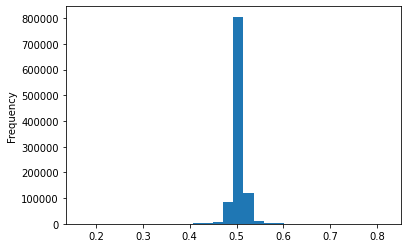

In [250]:
pd.Series(df_train['pred']).plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

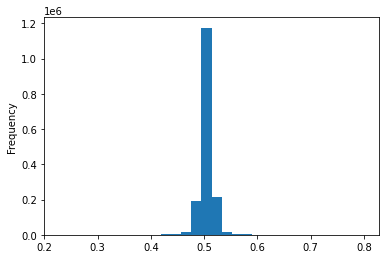

In [251]:
pd.Series(df_val['pred']).plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

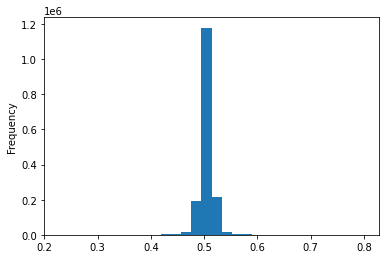

In [252]:
pd.Series(df_test['pred']).plot(kind='hist', bins=30)

### evaluation

In [253]:
from sklearn.metrics import mean_squared_error

In [254]:
print(f"\nTrain xgboost RMSE: {np.sqrt(mean_squared_error(df_train['pred'], df_train['target_20d']))}\n")
print(f"Test xgboost RMSE: {np.sqrt(mean_squared_error(df_train['pred'], df_train['target_20d']))}\n")


Train xgboost RMSE: 0.20696504658609305

Test xgboost RMSE: 0.20696504658609305



In [255]:
class CalcNumeraiMetrics:
    
    def __init__(self, y, y_pred):
        self.y = y
        self.y_pred = y_pred
    
    def calc_coef(self):

        # method="first" breaks ties based on order in array
        return np.corrcoef(self.y, self.y_pred.rank(pct=True, method="first"))[0,1]
    
    def calc_mmc(self):
        pass
    
    def calc_estimated_payout(self, stake_value, payout_factor, corr, corr_multiplier, mmc, mmc_multiplier):
        estimated_payout = stake_value * payout_factor * (corr * corr_multiplier + mmc * mmc_multiplier)
        return estimated_payout
    
    def calc_all_metrics(self):
        coef = self.calc_coef()
        metric_summary = {'coef': coef}
        return metric_summary

In [260]:
df_val

,date,bloomberg_ticker,open,high,low,close,adj_close,volume,currency,provider,...,feature_SMA_21_adj_close_diff_3,feature_SMA_21_adj_close_abs_diff_3,feature_SMA_21_adj_close_diff_4,feature_SMA_21_adj_close_abs_diff_4,friday_date,data_type,target_4d,target_20d,target,pred
0,2013-01-04,000120 KS,102000.0,108000.0,101500.0,107500.0,107500.0,57314.0,KRW,yahoo,...,0.0,0.0,0.0,0.0,2013-01-04,validation,0.75,0.50,0.50,0.498332
1,2013-01-11,000120 KS,115000.0,117500.0,112500.0,116000.0,116000.0,46729.0,KRW,yahoo,...,0.0,0.0,0.0,0.0,2013-01-11,validation,1.00,0.50,0.50,0.493242
2,2013-01-18,000120 KS,119000.0,119000.0,114000.0,116000.0,116000.0,59717.0,KRW,yahoo,...,0.0,0.0,0.0,0.0,2013-01-18,validation,0.25,0.00,0.00,0.501186
3,2013-01-25,000120 KS,120000.0,121500.0,115500.0,116000.0,116000.0,68902.0,KRW,yahoo,...,0.0,0.0,0.0,0.0,2013-01-25,validation,0.50,0.25,0.25,0.465621
4,2013-02-01,000120 KS,120000.0,126000.0,119000.0,123500.0,123500.0,63291.0,KRW,yahoo,...,0.0,0.0,0.0,0.0,2013-02-01,validation,0.50,0.00,0.00,0.498979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639820,2022-01-28,ZURN SW,446.0,446.0,436.1,441.0,441.0,483441.0,CHF,yahoo,...,0.0,0.0,0.0,0.0,2022-01-28,validation,0.50,0.50,0.50,0.499023
1639821,2022-02-04,ZURN SW,446.0,446.8,436.1,438.5,438.5,333009.0,CHF,yahoo,...,0.0,0.0,0.0,0.0,2022-02-04,validation,0.75,NaN,0.50,0.500291
1639822,2022-02-11,ZURN SW,448.1,451.7,445.1,451.7,451.7,398656.0,CHF,yahoo,...,0.0,0.0,0.0,0.0,2022-02-11,validation,0.50,NaN,0.50,0.494019
1639823,2022-02-18,ZURN SW,434.0,438.8,431.7,433.8,433.8,433037.0,CHF,yahoo,...,0.0,0.0,-1.0,1.0,2022-02-18,validation,0.50,NaN,0.50,0.498993


In [258]:
df_test.isnull().sum()

date                1645216
bloomberg_ticker    1645216
open                1645216
high                1645216
low                 1645216
                     ...   
data_type           1645216
target_4d           1645216
target_20d          1645216
target              1645216
pred                      0
Length: 89, dtype: int64

In [257]:
df_test

,date,bloomberg_ticker,open,high,low,close,adj_close,volume,currency,provider,...,feature_SMA_21_adj_close_diff_3,feature_SMA_21_adj_close_abs_diff_3,feature_SMA_21_adj_close_diff_4,feature_SMA_21_adj_close_abs_diff_4,friday_date,data_type,target_4d,target_20d,target,pred
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498332
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.493242
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.501186
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465621
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.509525
1645212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.509738
1645213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.516546
1645214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.493036


In [272]:
print(f"Train: {CalcNumeraiMetrics(df_train['target_20d'], df_train['pred']).calc_all_metrics()}\n")
print(f"Val: {CalcNumeraiMetrics(df_val['target_20d'], df_val['pred']).calc_all_metrics()}\n")
print(f"Test: {CalcNumeraiMetrics(df_test['target_20d'], df_test['pred']).calc_all_metrics()}\n")

### submit model

In [ ]:
output_dir = '~/csvs/'

In [ ]:
if output_dir is not None:
    os.makedirs(output_dir, exist_ok=True)
    example_signal_output_path = f'{output_dir}/{example_signal_output_path}'

df_test = df_test.drop_duplicates(subset=["bloomberg_ticker", "friday_date"], keep="first")
df_test[['bloomberg_ticker', 'friday_date', 'data_type', 'pred']].reset_index(drop=True).to_csv(example_signal_output_path, index=False)

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Signals example data pipeline')
    parser.add_argument('--output_dir', default=None)

    args = parser.parse_args()
    main(args.output_dir)